In [1]:
import sys
sys.path.append("..")
import functools

import numpy as np
import torch
import scipy.linalg
import scipy.optimize
import scipy.integrate
import matplotlib.pyplot as plt
from dict_minimize.torch_api import minimize
import functorch
import pyequion2

import tmcdiff

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
TK = 298.15
bulk_velocity = 1e0
pipe_diameter = 1e-2
species = ["C", "Ca", "Na", "Cl", "Mg"]
phases = ["Calcite", "Dolomite"]
c_nahco3 = 0.018
c_cacl2 = 0.006
c_nacl = 0.003
c_mgcl2 = 0.0003
molal_balance = {'C':c_nahco3,
                 'Ca':c_cacl2,
                 'Na':c_nahco3 + c_nacl,
                 'Cl':2*c_cacl2 + c_nacl + 2*c_mgcl2,
                 'Mg': c_mgcl2}
ngrid = 20
ypmax = 5

In [6]:
solver = tmcdiff.TransportSolver(species)
solver.set_flow_conditions(TK, bulk_velocity, pipe_diameter)
solver.set_initial_conditions(molal_balance, phases)
solver.build_transport(ngrid, ypmax)
solver.set_initial_guess()

In [7]:
solver.eqsys.solute_elements

['C', 'Ca', 'Cl', 'Mg', 'Na']

In [8]:
solver.load("results/restest3")

In [9]:
# solver.load("results/restest")

Text(0, 0.5, 'c [mol/kg H2O]')

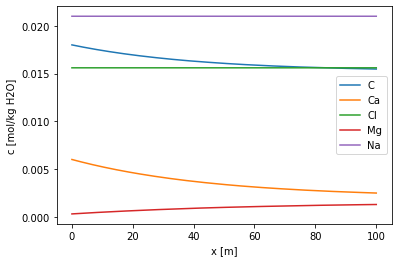

In [16]:
for i, el in enumerate(solver.eqsys.solute_elements):
    plt.plot(solver.t*bulk_velocity, solver.x[:, i], label=el)
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("c [mol/kg H2O]")

Text(0, 0.5, 'c [ln (mol/kg H2O)]')

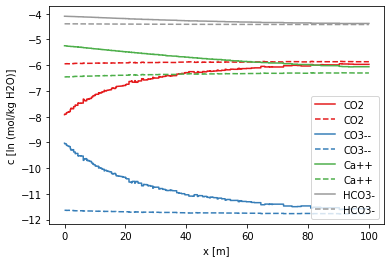

In [11]:
cmap = plt.get_cmap("Set1")
for i, el in enumerate(solver.eqsys.solutes):
    if el in ["CO2", "HCO3-", "Ca++", "CO3--"]:
        plt.plot(solver.t*bulk_velocity, solver.logc[:, i, -1], label=el, color=cmap(i), linestyle='-')
        plt.plot(solver.t*bulk_velocity, solver.logc[:, i, 0], label=el, color=cmap(i), linestyle='--')
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("c [ln (mol/kg H2O)]")

In [12]:
logg = solver.builder.activity_model_func(np.exp(np.moveaxis(solver.logc, -2, -1)), numpy=True)
logg = np.moveaxis(logg, -2, -1)
loga = logg + solver.logc
nu = solver.builder.reduced_reaction_vector.numpy()
logiap = np.einsum("ij, ljm -> lim", nu, loga)
logsatur = logiap - solver.builder.logk_solid[..., None].numpy()

Text(0, 0.5, 'S.I.')

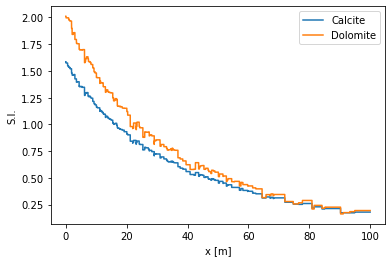

In [13]:
for i, phase in enumerate(solver.builder.phases):
    plt.plot(solver.t*bulk_velocity, logsatur[:, i, -1]/np.log(10), label=phase)
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("S.I.")

In [ ]:
1